# Solving an Inverse Problem with Physics-Informed Neural Networks (PINNs)

### Problem Statement:
We aim to find the scalar parameter $\alpha \in \mathbb{R}$ given a target function $\tilde{u}$. Specifically, we want to solve the following optimization problem:
$$
\text{arg}\min f(u,\tilde{u}) = \| u - \tilde{u} \|^2,
$$
where $u$ satisfies the boundary value problem described by a second-order Partial differential equation (PDE):
\begin{cases}
\displaystyle -\alpha \frac{d^2u}{dx^2} = f(x), \quad x \in \Omega = (0,1),\\​
 u(0) = u(1) =  0 . 
\end{cases}

### Given data:
The target function $\tilde{u}$ is given by:
$$\tilde{u} = \sin(\pi x)$$
  
The function $f(x)$, derived from the assumed true solution, is specified as:
$$f = 2 \pi^2 \sin(\pi x).$$

-----------------------------

# Objective

Our goal is to compute the value of $\alpha$ that best aligns the solution $u(x)$ of the PDE with the given $\tilde{u}(x)$.
To achieve this, we can utilize a Physics-Informed Neural Network (PINN) that integrates the differential equation as a part of its loss function.
This approach ensures that the learned solution not fits the data while respecting the underlying "physics" described by the PDE.

In [1]:

#todo sitemare il testo 
#? vogliamo aggiungere il calcolo dell'errore
#todo tenere traccia dei valori di alpha al variare delle epoche
#? animazione

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import time
import torch.nn as nn
import torch.optim as optim
from DNN import DeepNet

torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

I'm using:  cpu


/home/luca/.pyenv/versions/3.12.4/envs/torch/lib/python3.12/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
def convert(x):
  return x.cpu().detach().numpy()

In [4]:
input =1 
output =1
hidden_layer = 4*[50]
activation_function = nn.Tanh()

FNN = DeepNet(activation_function,input,hidden_layer,output)
alpha = nn.Parameter(torch.Tensor([1]).requires_grad_(True)).to(device)
FNN

DeepNet(
  (activation): Tanh()
  (hidden): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1-3): 3 x Linear(in_features=50, out_features=50, bias=True)
  )
  (output): Linear(in_features=50, out_features=1, bias=False)
)

In [5]:
x0 = torch.Tensor([0]).to(device)
x1 = torch.Tensor([1]).to(device)
u_b0 = torch.Tensor([0]).to(device)
u_b1 = torch.Tensor([0]).to(device)

n_train_points = 100
n_data_points  = 50
n_test_points  = 100

x_train = torch.rand([n_train_points,1])
x_data = torch.linspace(0,1,n_data_points).unsqueeze(1)
x_test = torch.linspace(0,1,n_test_points).unsqueeze(1)

Text(0.5, 1.0, 'Collocation Points')

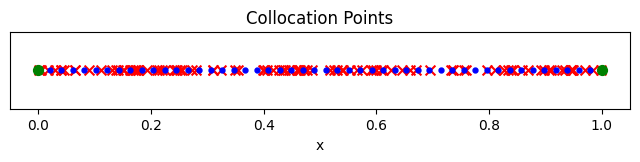

In [6]:
plt.figure(figsize=(8, 1),num =1)  
plt.scatter(convert(x_train), np.zeros_like(convert(x_train)), color='red', s=50, marker='x', label='Collocation Points')
plt.scatter(convert(x_data), np.zeros_like(convert(x_data)), color='blue', s=50, marker='.', label='Data Points')

plt.scatter(convert(x0), np.zeros_like(convert(x0)), color='green', s=50)
plt.scatter(convert(x1), np.zeros_like(convert(x1)), color='green', s=50)
plt.xlabel('x')
plt.yticks([])  
plt.title('Collocation Points')


In [7]:
def exact_sol(x):
    return torch.sin(torch.pi*x)

alpha_exact = 2

def rhs(x):
    return alpha_exact*torch.pi**2*torch.sin(torch.pi*x)

u_exact_train = exact_sol(x_train)
rhs_train = rhs(x_train)
u_exact_data = exact_sol(x_data)
u_exact_test = exact_sol(x_test)

In [8]:
def eval_loss_ode(Phi,x,rhs,alpha,metric):
    x.requires_grad_(True)

    u_NN = Phi(x)
    u_NN_x = torch.autograd.grad(u_NN.sum(),x,create_graph=True,retain_graph=True,allow_unused=True)[0]
    u_NN_xx = torch.autograd.grad(u_NN_x.sum(),x,create_graph=True)[0]

    return metric(-alpha*u_NN_xx, rhs(x))

def eval_loss_pt(Phi,x,y):
    return (Phi(x) -y ).pow(2).squeeze()

def eval_loss_data(Phi,x,data,metric):
    return metric(Phi(x),data)

In [ ]:
n_epochs = 10000
learining_rate = 1e-3
alpha = nn.Parameter(torch.Tensor([1]).to(device).requires_grad_(True)) #! l'ordine tra device e requires_grad e' fondamentale altrimenti non funziona perche' non e' un leaf

optimizer = optim.Adam(list(FNN.parameters())+[alpha],lr = 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,5000,0.5)

loss_values = np.empty([n_epochs+1,5]) #total,ode, b0,b1, data
alpha_values = np.empty([n_epochs+1])

MSE =  torch.nn.MSELoss()
STEP = 100 #save every 100 epochs

assert n_epochs%STEP == 0

err = np.empty([int(n_epochs/STEP)+1,2])
u_animate =  np.empty([int(n_epochs/STEP)+1,n_train_points])
err_animate = np.empty([int(n_epochs/STEP)+1,n_train_points])
k = 0 

for epoch in range(n_epochs+1):

    loss_ode = eval_loss_ode(FNN, x_train, rhs,alpha, MSE)

    loss_b0 = eval_loss_pt(FNN, x0, u_b0)
    loss_b1 = eval_loss_pt(FNN, x1, u_b1)

    loss_data = eval_loss_data(FNN,x_data,u_exact_data,MSE)

    loss = loss_ode +  loss_b0 + loss_b1  + 1.5*loss_data

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    loss_values[epoch,:] = np.stack([convert(loss),convert(loss_ode),convert(loss_b0),convert(loss_b1),convert(loss_data)])
    alpha_values[epoch] = alpha
    if epoch%STEP == 0:
      lr = np.array(scheduler.get_last_lr())
    #   u_NN_test =  FNN(x_test)
    #   err[k,:] = [L2_diff(convert(FNN(x_train)),u_exact_train), L2_diff(convert(u_NN_test),u_exact_test)]
    #   u_animate[k,:]  = convert(FNN(x_sort_train).squeeze())
    #   err_animate[k,:]= (np.abs(u_animate[k,:] - u_exact_train_sort.squeeze()))
      print(f'Epoch {epoch} || learning rate {lr.squeeze():.2e}  || Error  Train {err[k,0]:.2e} || Error Test  {err[k,1]:.2e}''\n'
            f'Global loss {loss_values[epoch,0]:.2e} || loss ode {loss_values[epoch,1]:.2e} || loss b0 {loss_values[epoch,2]:.2e} || loss b1 {loss_values[epoch,3]:.2e} || loss data {loss_values[epoch,4]:.2e}','\n')
      k+=1

Epoch 0 || learning rate 1.00e-03  || Error  Train 6.41e-310 || Error Test  6.41e-310
Global loss 1.96e+02 || loss ode 1.95e+02 || loss b0 0.00e+00 || loss b1 1.68e-03 || loss data 5.20e-01 

Epoch 100 || learning rate 1.00e-03  || Error  Train 4.93e-310 || Error Test  4.93e-310
Global loss 1.58e+01 || loss ode 1.00e+01 || loss b0 1.72e+00 || loss b1 2.56e+00 || loss data 9.69e-01 

Epoch 200 || learning rate 1.00e-03  || Error  Train 0.00e+00 || Error Test  4.99e-322
Global loss 7.38e-01 || loss ode 4.01e-01 || loss b0 2.38e-03 || loss b1 1.01e-01 || loss data 1.56e-01 

Epoch 300 || learning rate 1.00e-03  || Error  Train 3.40e-313 || Error Test  1.70e-313
Global loss 3.53e-01 || loss ode 5.77e-02 || loss b0 2.65e-02 || loss b1 5.88e-02 || loss data 1.40e-01 

Epoch 400 || learning rate 1.00e-03  || Error  Train 0.00e+00 || Error Test  0.00e+00
Global loss 3.15e-01 || loss ode 2.58e-02 || loss b0 3.58e-02 || loss b1 4.85e-02 || loss data 1.36e-01 

Epoch 500 || learning rate 1.00e-03

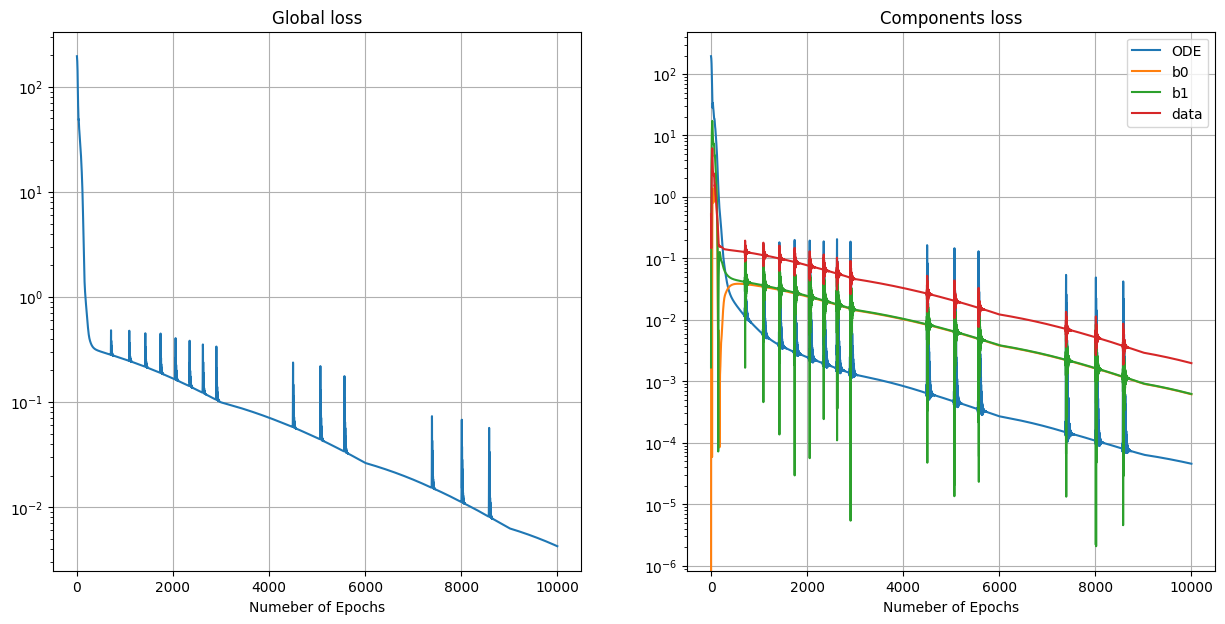

In [14]:
epochs = range(n_epochs+1)
#y_lims = [np.min(loss_values)*0.8,np.max(loss_values)*1.2]

fig, axs = plt.subplots(1,2,figsize = (15,7), num =4)
axs[0].semilogy(epochs,loss_values[:,0])
axs[0].set_xlabel('Numeber of Epochs')
#axs[0].set_ylim(y_lims)
axs[0].grid('on')
axs[0].set_title('Global loss')

axs[1].semilogy(epochs,loss_values[:,1],label = 'ODE')
axs[1].semilogy(epochs,loss_values[:,2],label = 'b0' )
axs[1].semilogy(epochs,loss_values[:,3],label = 'b1' )
axs[1].semilogy(epochs,loss_values[:,4],label = 'data' )
axs[1].set_xlabel('Numeber of Epochs')
#axs[1].set_ylim(y_lims)
axs[1].legend()
axs[1].grid('on')
axs[1].set_title('Components loss')

plt.show()

In [15]:
u_NN_test = convert(FNN(x_test))
x_test = convert(x_test)

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

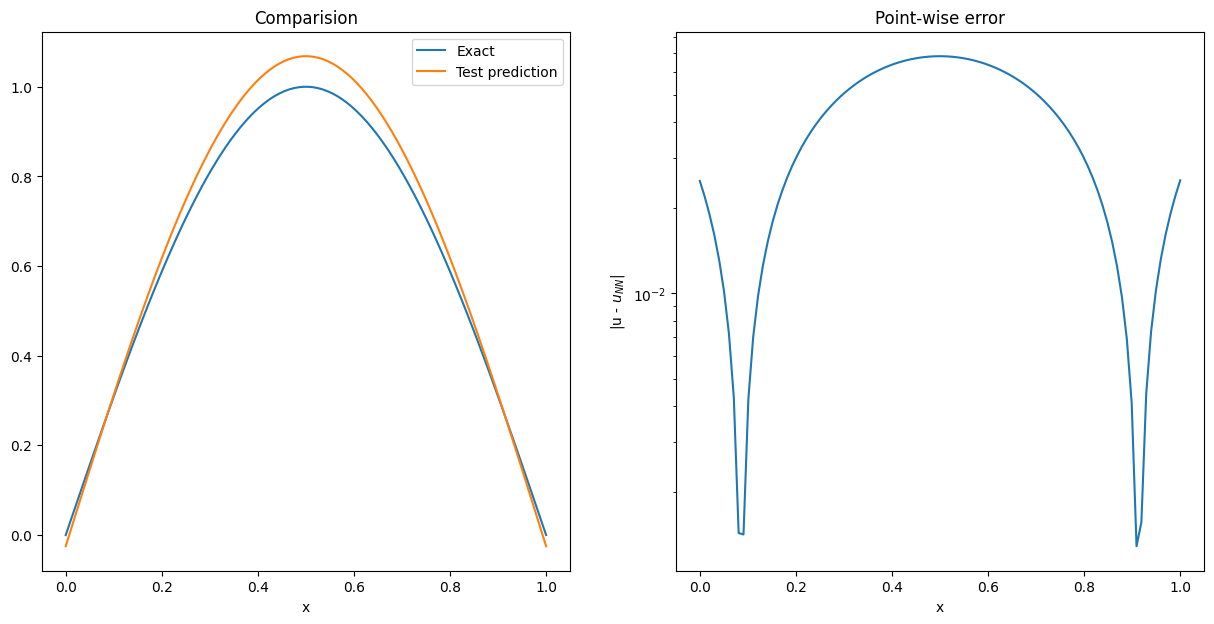

In [16]:
fig, axs = plt.subplots(1,2,figsize = (15,7))
axs[0].plot(x_test,convert(u_exact_test),label = 'Exact')
axs[0].plot(x_test,u_NN_test, label = 'Test prediction')
axs[0].set_xlabel('x')
axs[0].legend()
axs[0].set_title('Comparision')

axs[1].semilogy(x_test,np.abs(convert(u_exact_test)-u_NN_test))
axs[1].set_title('Point-wise error')
axs[1].set_xlabel('x')
axs[1].set_ylabel('|u - $u_{NN}$|')
plt.show()

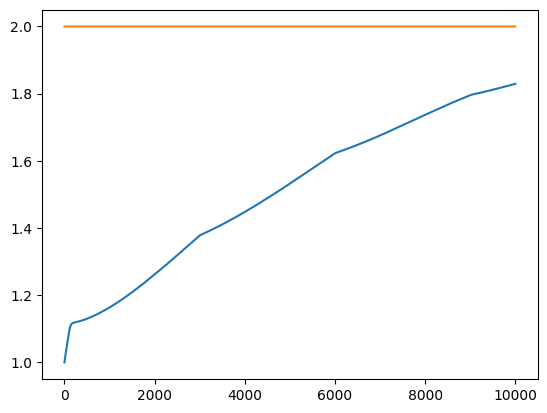

In [17]:
plt.plot(epochs,alpha_values)
plt.plot(epochs,alpha_exact*np.ones(alpha_values.shape))